In [1]:
%matplotlib inline
import netCDF4
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt
from os.path import join

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF/
/home/ikeuchi/Share/GLOFRIM/glofrim


## create PCR model BMI object

Note that we use a two step initializiation. in the first step the bmi object is initialized and the model config file is read into memory. This config file can then be changed offline before the model is initialized. This allows for change model input files and setting based on the model coupling.

In [5]:
PCR_configfile = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')

PCR_bmi = PCR_model(PCR_configfile, PCR_in_dir, PCR_out_dir,
                            start_date, end_date)


The illustrate the two-step initialization, the model config file is shown

In [6]:
PCR_bmi.model_config

OrderedDict([(u'globalOptions',
              OrderedDict([('inputDir',
                            u'/home/ikeuchi/Share/GLOFRIM/glofrim/test_Elbe/PCR_Elbe/input30min'),
                           ('cloneMap', u'clone_elbe_30min.map'),
                           ('landmask', u'landmask_elbe_30min.map'),
                           ('outputDir',
                            u'/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF/PCR'),
                           ('institution',
                            u'Department of Physical Geography, Utrecht University'),
                           ('title', u'PCR-GLOBWB output'),
                           ('description',
                            u'test version by Edwin H. Sutanudjaja; adapted by J. Hoch'),
                           ('startTime', '2000-01-01'),
                           ('endTime', '2001-12-31'),
                           ('maxSpinUpsInYears', u'1'),
                           ('minConvForTotlSto', u'0.5'),
     

## create CMF model BMi object

In [7]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date)

## couple grids based on CMF inpmat file

In [8]:
# couple
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## initialize models

In [9]:
# initialize model at CMF_out_dir after inpmat has been set in the grid_to_grid coupling function.
CMF_bmi.initialize()
# initialize model 
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-22 11:16:45.620845
2018-03-22 11:16:45,933 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-22 11:16:45.620845
INFO: configuration.initialize_logging(): Logging output to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-22T11:16:45.620845.log
2018-03-22 11:16:45,942 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-22T11:16:45.620845.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-22 11:16:45,959 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used i

## run coupled PCR - CMF model

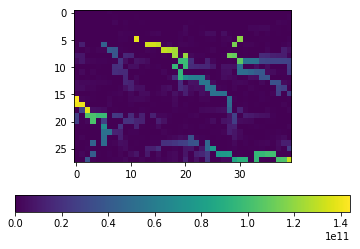

In [10]:
#- get upsteram area at comparison point in CMF
#upArea = np.fromfile(r'/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/CMF_Elbe/uparea.bin', 'f').reshape(28,40)
upArea = np.fromfile(join(cwd, r'test_Elbe/CMF_Elbe/uparea.bin'), 'f').reshape(28,40)
plt.imshow(upArea)
plt.colorbar(orientation='horizontal')

In [11]:
#- check whether upstream area at chosen location is at the upper end
#- upstream area according to GRDC: 131950 km2 = 1.31950e11 m2
xCMFout = 6
yCMFout = 13
print (upArea[xCMFout, yCMFout])

1.34112e+11


In [12]:
# create file for writing CMF output
cmf_outFile = os.path.join(CMF_out_dir, 'qsim_CFM_at_location_' + str(xCMFout) + '_' + str(yCMFout) + '.txt')
cmf_of = open(cmf_outFile, 'w')
print (cmf_of)

<open file u'/home/ikeuchi/Share/GLOFRIM/work/GLOFRIM-CAMA/output30minPCR2CMF/CMF/qsim_CFM_at_location_6_13.txt', mode 'w' at 0x7f892a4de9c0>


In [13]:
# run coupled model for 20 timesteps
def update_states():
    "coupling runoff between CMFan PCR model"
#     runoff = PCR_bmi.get_var('landSurfaceRunoff')
    runoff = PCR_bmi.get_var('runoff')
    runoff = np.where(np.isnan(runoff), 0, runoff)
    CMF_bmi.set_var("roffin", runoff)
        
tStart = datetime.now()
#for i in range(timeSteps):
for i in range(10):
    PCR_bmi.update()
    update_states()
    CMF_bmi.update()  
    outflw_temp = np.copy(CMF_bmi.get_var('outflw'))[xCMFout, yCMFout]
    cmf_of.write(str(outflw_temp) + os.linesep)
tEnd = datetime.now()
cmf_of.close()

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-22 11:16:58,333 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-22 11:16:58,582 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-22 11:17:00,614 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-22 11:17:00,632 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-02
2018-03-22 11:17:00,640 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
INFO

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-11
2018-03-22 11:17:12,123 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11
INFO: pcrglobwb.update(): updating model to time 2000-01-11
2018-03-22 11:17:12,349 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-03-22 11:17:13,343 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
2018-03-22 11:17:13,373 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-12
2018-03-22 11:17:13,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12
IN

In [43]:
CMF_logfile = os.path.join(CMF_out_dir, 'out/run_2000.log')
cmf_lf = open(CMF_logfile, 'r')
WB_error = float(cmf_lf.readlines()[-1].split()[-2]) * 10e9
print('Water balance error in CMF: {} m3'.format(WB_error))


Water balance error in CMF: 9.76e-06 m3


In [ ]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# PCR_bmi.update()
# routingModel.update_states()
# routingModel.update() 

runoff = PCR_bmi.get_var('landSurfaceRunoff')
outflw = CMF_bmi.get_var('outflw')
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = CMF_bmi.get_var('rivsto_out')
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [ ]:
# finalize model
PCR_bmi.finalize()

# finalize model
CMF_bmi.finalize()

In [ ]:
import matplotlib.dates as mdates
from netCDF4 import Dataset

#- laod DFM output file (from 1way coupled PCR->DFM run)
fo_1way = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_1way_his.nc')
#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- load PCR file
po = os.path.join(cwd, 'test_Elbe/', 'Qsim_Elbe_Darchau_30min_2000s_industrial_prefactored.dump')

#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- estract PCR data
pd = np.loadtxt(po, unpack=True, skiprows=4)
PCR_ND = pd[1]
PCR_ND = PCR_ND[:]

#- extrat CMF data
cd = np.loadtxt(cmf_outFile, unpack=True)

#- extract simulated discharge from nc-file for 1way PCR->DFM
no_1way = Dataset(fo_1way, 'r')
qsim_1way = no_1way.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_1way = np.absolute(qsim_1way[:,2])
qsim_ND_1way = np.absolute(qsim_1way[:,0])
qsim_downBC_1way = np.absolute(qsim_1way[:,1])

#- extract simulated discharge from nc-file for DFM standalone
no_stA = Dataset(fo_stA, 'r')
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- limit to list with least entries
minLength = min(len(qsim_ND_1way), len(qsim_ND_stA), len(PCR_ND), len(cd))
if len(qobs_ND) > len(cd):
    qobs_ND = qobs_ND[:minLength]
    PCR_ND = PCR_ND[:minLength]
    qsim_ND_1way = qsim_ND_1way[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    cd = cd[:minLength]

#- computed KGE at NeuDarchau
KGE_ND_1way = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_1way)
KGE_ND_1way = np.round(KGE_ND_1way,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)
KGE_ND_PCR = spotpy.objectivefunctions.kge(qobs_ND, PCR_ND)
KGE_ND_PCR = np.round(KGE_ND_PCR,2)
KGE_ND_CMF = spotpy.objectivefunctions.kge(qobs_ND, cd)
KGE_ND_CMF = np.round(KGE_ND_CMF,2)

#- plot
plt.figure(figsize=(16,8))
# plt.plot(qsim_downBC, ':', c='r', label = 'Qsim downBC')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qsim_ND_1way, 'r', label = 'PCR->DFM')
# plt.plot(qsim_downBC, ':',  c='k', label = 'Qsim downBC')
plt.plot(PCR_ND, ':',label = 'PCR')
plt.plot(cd, c='c', label = 'PCR->CMF')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(minLength+1,4900, 'KGEs') 
plt.text(minLength+1,4750, 'PCR : '+str(KGE_ND_PCR))
plt.text(minLength+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(minLength+1,4450, 'PCR->DFM : '+str(KGE_ND_1way))
plt.text(minLength+1,4300, 'PCR->CMF : '+str(KGE_ND_CMF))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim_PCR2CMF.png'), dpi=300)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(qsim_ND_1way, 'r',label = 'PCR->DFM')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))